In [15]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import cv2 
import numpy as np

In [ ]:
import os

num_skipped = 0
for folder_name in ("Cat", "Dog"):
    folder_path = os.path.join("PetImages", folder_name)
    for fname in os.listdir(folder_path):
        fpath = os.path.join(folder_path, fname)
        try:
            fobj = open(fpath, "rb")
            is_jfif = tf.compat.as_bytes("JFIF") in fobj.peek(10)
        finally:
            fobj.close()

        if not is_jfif:
            num_skipped += 1
            # Delete corrupted image
            os.remove(fpath)

print("Deleted %d images" % num_skipped)


In [ ]:
image_size = (64, 64)
batch_size = 32

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    "PetImages/",
    validation_split=0.2,
    subset="training",
    seed=1337,
    image_size=image_size,
    batch_size=batch_size,
)
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    "PetImages",
    validation_split=0.2,
    subset="validation",
    seed=1337,
    image_size=image_size,
    batch_size=batch_size,
)


Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


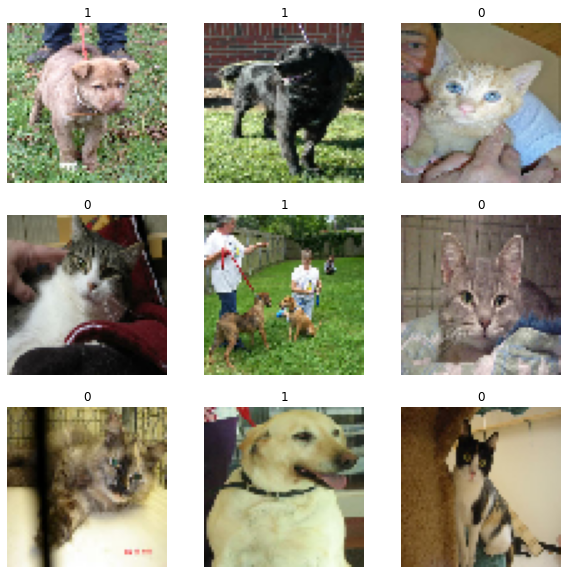

In [92]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(int(labels[i]))
        plt.axis("off")


In [93]:
data_augmentation = keras.Sequential(
    [
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.1),
    ]
)


Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


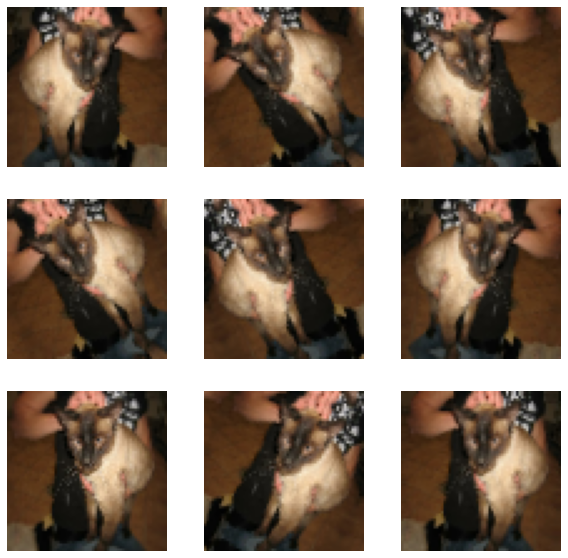

In [94]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
    for i in range(9):
        augmented_images = data_augmentation(images)
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(augmented_images[0].numpy().astype("uint8"))
        plt.axis("off")


In [95]:
augmented_train_ds = train_ds.map(
  lambda x, y: (data_augmentation(x, training=True), y))


In [96]:
train_ds = train_ds.prefetch(buffer_size=32)
val_ds = val_ds.prefetch(buffer_size=32)


In [ ]:
def make_model(input_shape, num_classes):
    inputs = keras.Input(shape=input_shape)
    # Image augmentation block
    x = data_augmentation(inputs)

    # Entry block
    x = layers.Rescaling(1.0 / 255)(x)
    x = layers.Conv2D(32, 3, strides=2, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    x = layers.Conv2D(64, 3, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    previous_block_activation = x  # Set aside residual

    for size in [128, 256, 512, 728]:
        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(size, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(size, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.MaxPooling2D(3, strides=2, padding="same")(x)

        # Project residual
        residual = layers.Conv2D(size, 1, strides=2, padding="same")(
            previous_block_activation
        )
        x = layers.add([x, residual])  # Add back residual
        previous_block_activation = x  # Set aside next residual

    x = layers.SeparableConv2D(1024, 3, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    x = layers.GlobalAveragePooling2D()(x)
    if num_classes == 2:
        activation = "sigmoid"
        units = 1
    else:
        activation = "softmax"
        units = num_classes

    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(units, activation=activation)(x)
    return keras.Model(inputs, outputs)


model = make_model(input_shape=image_size + (3,), num_classes=2)
keras.utils.plot_model(model, show_shapes=True)


In [ ]:
epochs = 10

callbacks = [
    keras.callbacks.ModelCheckpoint("save_at_{epoch}.h5"),
]
model.compile(
    optimizer=keras.optimizers.Adam(1e-3),
    loss="binary_crossentropy",
    metrics=["accuracy"],
)
history= model.fit(
    train_ds, epochs=epochs, callbacks=callbacks, validation_data=val_ds,
)


In [104]:
xaxis = [*range(1,11,1)]

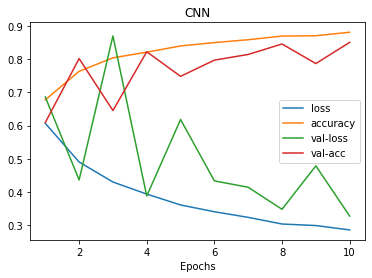

In [108]:
import matplotlib.pyplot as plt

x_data = xaxis
y_data = history.history['val_accuracy']
y_data2 = history.history["loss"]
y_data3 = history.history['accuracy']
y_data4 = history.history['val_loss']

fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)

ax.plot(x_data, y_data2, label='loss')
ax.plot(x_data, y_data3, label='accuracy')
ax.plot(x_data, y_data4, label='val-loss')
ax.plot(x_data, y_data, label="val-acc")


plt.xlabel("Epochs")
plt.ylabel("")
plt.title("CNN")

plt.legend()

plt.show()

In [32]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 64, 64, 3)]  0           []                               
                                                                                                  
 sequential (Sequential)        (None, 64, 64, 3)    0           ['input_1[0][0]']                
                                                                                                  
 rescaling (Rescaling)          (None, 64, 64, 3)    0           ['sequential[0][0]']             
                                                                                                  
 conv2d (Conv2D)                (None, 32, 32, 32)   896         ['rescaling[0][0]']              
                                                                                              

In [101]:
model.save('cnnmodel_saved.h5')

In [3]:
from keras.models import load_model
import matplotlib.pyplot as plt

In [ ]:
mymodel = load_model('cnnmodel_saved.h5')

In [6]:
image_size = (64, 64)
batch_size = 32

Corrupt JPEG data: 252 extraneous bytes before marker 0xd9


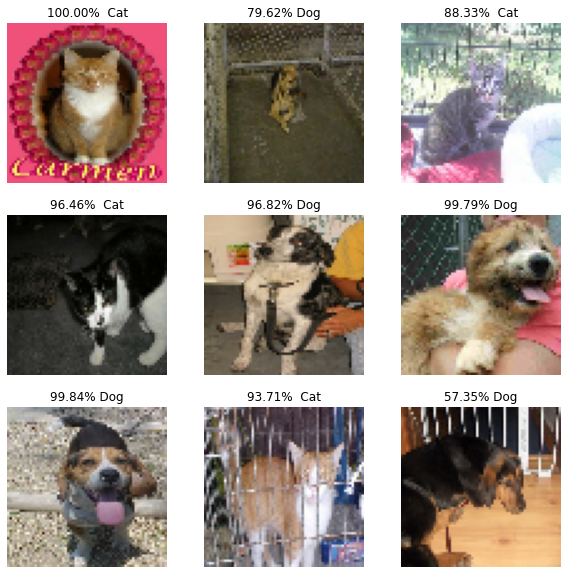

In [73]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in val_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        prediction=mymodel.predict(images[i].numpy().astype("uint8").reshape(1,64, 64, 3))
        predic = prediction[0][0]
        if predic > 0.5:
            tahmin = str(format(predic*100,".2f")) + "% Dog"
        else:
            tahmin = str(format((1-predic)*100,".2f")) + "%  Cat"
        plt.title((tahmin))
        plt.axis("off")